In [1]:
import os
import numpy as np
import torch
import torch.nn as nn
import torch.nn.functional as F


from IPython.display import Image
from torchvision.transforms import ToPILImage
from einops import rearrange, reduce, repeat

import matplotlib.pyplot as plt

from torchvision.transforms import RandomPerspective

import nvdiffrast.torch as dr


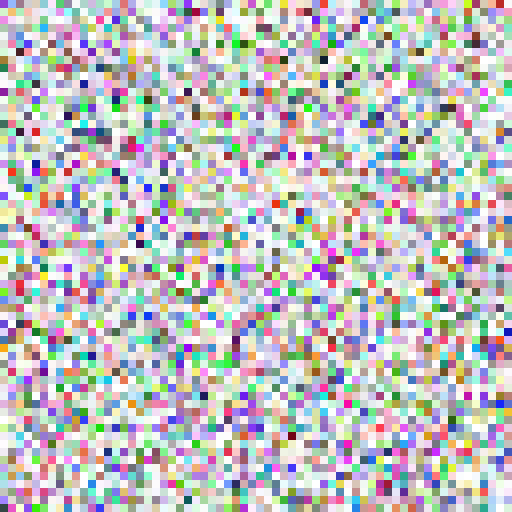

In [2]:

to_img = ToPILImage()

# Make test noise

test_noise = torch.randn(1,4,64,64)
up_level = 3

# Just for visualization

view_test_noise = F.interpolate(test_noise, size=(512,512), mode='nearest')
to_img(view_test_noise[0])


In [3]:

def cond_noise_sampling(src_noise, level=3):
    
    B, C, H, W = src_noise.shape
    
    up_factor = 2 ** level
    
    upscaled_means = F.interpolate(src_noise, scale_factor=(up_factor, up_factor), mode='nearest')
    
    up_H = up_factor * H
    up_W = up_factor * W
    
    """
        1) Unconditionally sample a discrete Nk x Nk Gaussian sample
    """
    
    raw_rand = torch.randn(B, C, up_H, up_W)
    
    """
        2) Remove its mean from it
    """
    
    squared_rand = rearrange(raw_rand, 'b c (h1 h2) (w1 w2) -> b c (h1 w1) (h2 w2)', h2=up_factor, w2=up_factor)
    squared_means = torch.mean(squared_rand, dim=-1)[...,None].repeat(1,1,1,up_factor * up_factor)
    resized_means = rearrange(squared_means, 'b c (h1 w1) (h2 w2) -> b c (h1 h2) (w1 w2)', h2=up_factor, w1 = W)
    
    mean_removed_rand = raw_rand - resized_means
    
    """
        3) Add the pixel value to it
    """

    up_noise = upscaled_means / up_factor + mean_removed_rand
    
    return up_noise


def cond_noise_sampling_two(src_noise, level=3):
    
    B, C, H, W = src_noise.shape
    
    up_factor = 2 ** level
    
    upscaled_means = F.interpolate(src_noise, scale_factor=(up_factor, up_factor), mode='nearest')
    
    up_H = up_factor * H
    up_W = up_factor * W
    
    """
        1) Unconditionally sample a discrete Nk x Nk Gaussian sample
    """
    
    raw_rand = torch.randn(B, C, up_H, up_W)
    
    """
        2) Remove its mean from it
    """
    
    Z_mean = raw_rand.unfold(2, up_factor, up_factor).unfold(3, up_factor, up_factor).mean((4, 5))
    Z_mean = F.interpolate(Z_mean, scale_factor=up_factor, mode='nearest')
    mean_removed_rand = raw_rand - Z_mean
    
    """
        3) Add the pixel value to it
    """

    up_noise = upscaled_means / up_factor + mean_removed_rand
    
    return up_noise


torch.Size([1, 4, 512, 512])


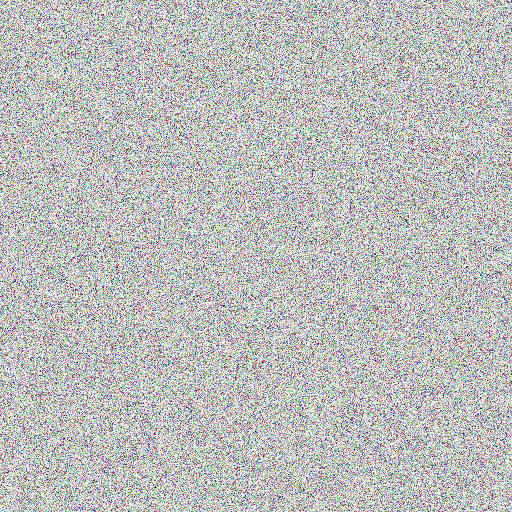

In [4]:
up_noise = cond_noise_sampling_two(test_noise, level=up_level)

test_noise_vis = F.interpolate(up_noise, size=(512,512), mode='nearest')

print(test_noise_vis.shape)

to_img(test_noise_vis[0])

In [5]:

# Target to Source Mapping will have twice the resolution
    
src_noise = test_noise

B, C, H, W = src_noise.shape


## Making Pseudo-Warped Coords

warp_i, warp_j = torch.meshgrid(
        torch.arange(W * 2 + 1),
        torch.arange(H * 2 + 1),
        indexing="ij",
    )

warp_idxs = torch.stack((warp_i, warp_j), dim=-1)

tgt_to_src_map = warp_idxs

# warp_idxs =  (torch.stack((warp_i, warp_j), dim=-1) - torch.tensor([W,W])[None,None,...]) / 1

# deg = torch.tensor([0.02])

# rotmat = torch.tensor([[torch.cos(deg), -torch.sin(deg)], [torch.sin(deg), torch.cos(deg)]])

# tgt_to_src_map = (rotmat[None,None,...] @ warp_idxs[...,None]).squeeze() * 1.0 + torch.tensor([W,W])[None,None,...]


print(tgt_to_src_map)

64
tensor([[[  0,   0],
         [  0,   1],
         [  0,   2],
         ...,
         [  0, 126],
         [  0, 127],
         [  0, 128]],

        [[  1,   0],
         [  1,   1],
         [  1,   2],
         ...,
         [  1, 126],
         [  1, 127],
         [  1, 128]],

        [[  2,   0],
         [  2,   1],
         [  2,   2],
         ...,
         [  2, 126],
         [  2, 127],
         [  2, 128]],

        ...,

        [[126,   0],
         [126,   1],
         [126,   2],
         ...,
         [126, 126],
         [126, 127],
         [126, 128]],

        [[127,   0],
         [127,   1],
         [127,   2],
         ...,
         [127, 126],
         [127, 127],
         [127, 128]],

        [[128,   0],
         [128,   1],
         [128,   2],
         ...,
         [128, 126],
         [128, 127],
         [128, 128]]])


In [6]:

tr_W = W * 2 + 1
tr_H = H * 2 + 1

i, j = torch.meshgrid(
        torch.arange(tr_W, dtype=torch.int32),
        torch.arange(tr_H, dtype=torch.int32),
        indexing="ij",
    )

mesh_idxs = torch.stack((i,j), dim=-1)
reshaped_mesh_idxs = mesh_idxs.reshape(-1,2)

# print(mesh_idxs)
print(mesh_idxs.shape)
print(reshaped_mesh_idxs)
# print()

print(reshaped_mesh_idxs.shape)



torch.Size([129, 129, 2])
tensor([[  0,   0],
        [  0,   1],
        [  0,   2],
        ...,
        [128, 126],
        [128, 127],
        [128, 128]], dtype=torch.int32)
torch.Size([16641, 2])


In [7]:
front_tri_verts = torch.tensor([[0, 1, 1+tr_H], [0, tr_H, 1+tr_H], [tr_H, 1+tr_H, 1+2*tr_H], [tr_H, 2*tr_H, 1+2*tr_H]])
per_tri_verts = torch.cat((front_tri_verts, front_tri_verts + 1),dim=0)

print(per_tri_verts)

# per_tri_verts = torch.tensor([[0, tr_H, 1+tr_H], [0, 1, 1+tr_H]])

print(tr_W - 3)

width = torch.arange(0, tr_W - 1, 2)
height = torch.arange(0, tr_H-1, 2) * (tr_W)
width_l = torch.linspace(0, tr_W-2, tr_W-1)
# height = torch.linspace(0, tr_H-2, tr_H-1) * (tr_W)

# print(width_l)
# print(height)

start_idxs = (width[None,...] + height[...,None]).reshape(-1,1)

# print(start_idxs)

vertices = (start_idxs.repeat(1,8)[...,None] + per_tri_verts[None,...]).reshape(-1,3)

num_faces = vertices.shape[0]
print(vertices.shape)
print(vertices)

tensor([[  0,   1, 130],
        [  0, 129, 130],
        [129, 130, 259],
        [129, 258, 259],
        [  1,   2, 131],
        [  1, 130, 131],
        [130, 131, 260],
        [130, 259, 260]])
126
torch.Size([32768, 3])
tensor([[    0,     1,   130],
        [    0,   129,   130],
        [  129,   130,   259],
        ...,
        [16381, 16510, 16511],
        [16510, 16511, 16640],
        [16510, 16639, 16640]])


In [8]:
idx_y = reshaped_mesh_idxs[:,0].int()
idx_x = reshaped_mesh_idxs[:,1].int()

print(idx_y)
print(reshaped_mesh_idxs)

# Nvdiffrast is actually x,y, so it must be flipped!!
warped_coords = tgt_to_src_map[idx_y, idx_x].fliplr()
coords_len = idx_y.shape[0]

print(warped_coords.shape)
print(coords_len)

# For original verification!
ori_mesh_idxs = reshaped_mesh_idxs.fliplr().clone()


tensor([  0,   0,   0,  ..., 128, 128, 128], dtype=torch.int32)
tensor([[  0,   0],
        [  0,   1],
        [  0,   2],
        ...,
        [128, 126],
        [128, 127],
        [128, 128]], dtype=torch.int32)
torch.Size([16641, 2])
16641


16641
torch.Size([1, 16641, 4])


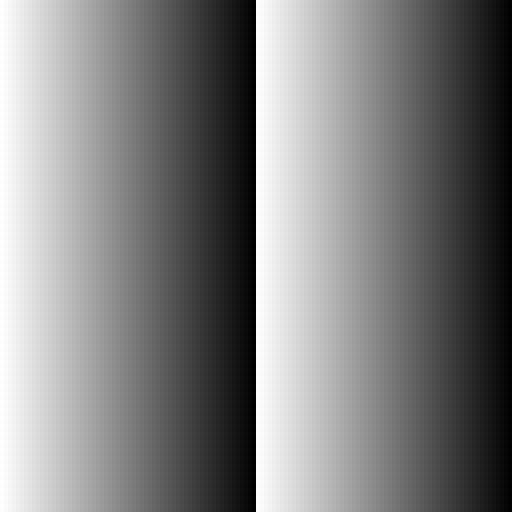

In [11]:
resolution= H * (2 ** up_level)
device = "cuda"
use_opengl = True
glctx = dr.RasterizeGLContext() if use_opengl else dr.RasterizeCudaContext()

# warped_vtx_pos =torch.cat(((warped_coords - H) / H, torch.zeros(coords_len, 1), torch.ones(coords_len, 1)), dim=-1)

print(coords_len)

warped_vtx_pos =torch.cat(((warped_coords - H) / H, torch.zeros(coords_len, 1), torch.ones(coords_len, 1)), dim=-1)

# print(warped_vtx_pos)

# To avoid ranged
warped_vtx_pos = warped_vtx_pos[None,...].to(device)
vertices = vertices.int().to(device) 

print(warped_vtx_pos.shape)
# print(vertices[:40])

with torch.no_grad():
    rast_out, _ = dr.rasterize(glctx, warped_vtx_pos, vertices, resolution=[resolution, resolution])

rast = rast_out[:,:,:,3:].permute(0,3,1,2).int()

# print(torch.max(rast))
# print(rast.shape)
# print(rast[0,0,50:100,50:100])

# Original Shape Verification
# ori_mesh_idx =torch.cat(((ori_mesh_idxs.to(device) - H) / H, torch.zeros(warped_coords.shape[0], 1).to(device), torch.ones(warped_coords.shape[0], 1).to(device)), dim=-1).to(device)[None,...]
# print(warped_vtx_pos)

# with torch.no_grad():
#     ori_rast_out, _ = dr.rasterize(glctx, ori_mesh_idx, vertices, resolution=[resolution, resolution])

# ori_rast = ori_rast_out[:,:,:,3:].to(dtype=torch.int16).permute(0,3,1,2).clone().detach()

# print(ori_mesh_idx[:,:11])

# Visualization

up_noise_vis = F.interpolate(rast.float(), size=(512,512), mode='nearest')
# ori_noise_vis = F.interpolate(ori_rast, size=(512,512), mode='nearest')

to_img(up_noise_vis[0].float())

# print(rast.shape)



tensor(1, device='cuda:0', dtype=torch.int32)
4
torch.Size([10, 4])
tensor([[ 17.2062,  -4.5037, -11.1789,  ..., -10.3768,   8.3245,  -7.8424],
        [ -0.7777,   6.6210,   0.1549,  ...,  18.8954,   3.2805,  -2.2190],
        [ 17.2372,   4.4606, -10.3780,  ...,  -1.7153, -11.0281,  -1.8116],
        [-14.6738,   4.2272,  -8.0567,  ...,  -5.9314,  -2.1142,  15.4778]])
tensor([[64., 64., 64.,  ..., 64., 64., 64.],
        [64., 64., 64.,  ..., 64., 64., 64.],
        [64., 64., 64.,  ..., 64., 64., 64.],
        [64., 64., 64.,  ..., 64., 64., 64.]])


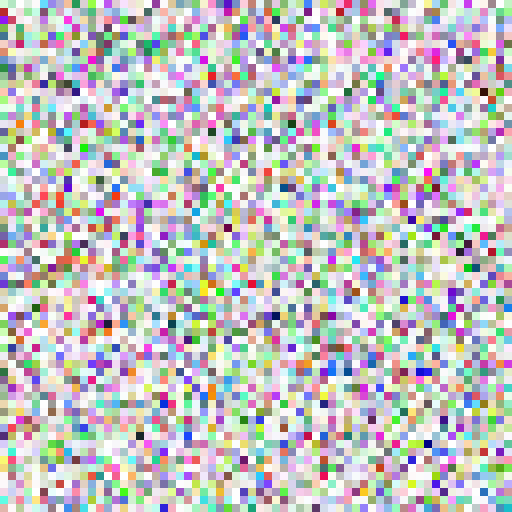

In [11]:
uni_idx = torch.unique(rast).to(device)

print(uni_idx[0])

if uni_idx[0] == 0:
    print("true")
    uni_idx = uni_idx[1:]
    
nonzero_list = []

for idx in uni_idx:
    nonzeros = torch.nonzero(rast == idx)
    nonzero_list.append(nonzeros)

# print(nonzero_list[0])

vert_canvas = torch.zeros((C,num_faces + 1))
vert_canvas_num_idx = torch.zeros((C,num_faces + 1))

print(vert_canvas.shape[0])

print(nonzero_list[0].shape)

# for k in nonzero_list[0]:
#     print(k)

for value, val_indice in enumerate(nonzero_list):
    
    id = uni_idx[value]
    
    for k in val_indice:
        vert_canvas[:,id] += up_noise[0,:,k[2],k[3]]
        vert_canvas_num_idx[:,id] += 1

reshaped_v = vert_canvas[:,1:].reshape(C,-1,8)
reshaped_v_num = vert_canvas_num_idx[:,1:].reshape(C,-1,8)

fin_v_val = reshaped_v.sum(dim=-1)
fin_v_num = reshaped_v_num.sum(dim=-1)

final_values = fin_v_val / torch.sqrt(fin_v_num)

print(fin_v_val)
print(fin_v_num)
# print(final_values.shape)


up_vis = F.interpolate(final_values.reshape(1,C,H,W).float(), size=(512,512), mode='nearest')

# print(up_noise_vis.shape)

to_img(up_vis[0])

# print(torch.mean(final_values))
# save_image(fina)

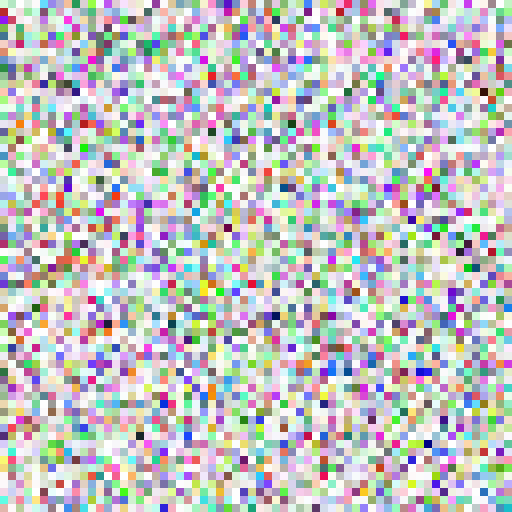

In [12]:
view_test_noise = F.interpolate(test_noise, size=(512,512), mode='nearest')
to_img(view_test_noise[0])

In [21]:
print(torch.max(rast))

# 0 not counted in the index
uni_idx = torch.unique(rast)[1:].to(device).to(dtype=torch.int16)

# Per-mask indices, batchify
num_batch = uni_idx.shape[0] // 500
batch_list = []

print(num_batch)

for i in range(num_batch):
    
    batch_uni_idx = uni_idx[None,i*500:(i+1)*500]

    mask_one = rast - (batch_uni_idx[None,...,None,None] - 1)
    mask_two = rast - (batch_uni_idx[None,...,None,None] - 2)

    one_rast = torch.clamp(mask_one, min=0)
    two_rast = torch.clamp(mask_two, min=0)

    fin_mask = torch.clamp((two_rast - one_rast * 5),min=0,max=1)
    
    batch_list.append(fin_mask)
    
# mask_one = rast - (uni_idx[None,...,None,None] - 1)
# mask_two = rast - (uni_idx[None,...,None,None] - 2)

# one_rast = torch.clamp(mask_one, min=0)
# two_rast = torch.clamp(mask_two, min=0)

# fin_mask = torch.cat((torch.clamp((two_rast - one_rast * 100),min=0,max=1)[:,1:],one_rast[:,127:]),dim=1)

# print(fin_mask.shape)

# Visualization
# want = fin_mask[:,128,:,:].unsqueeze(dim=1)
# new_noise_vis = F.interpolate(want, size=(512,512), mode='nearest') 
# to_img(new_noise_vis[0].float())

tensor(32510, device='cuda:0', dtype=torch.int16)
torch.Size([1, 1, 512, 512])
64


In [40]:
rand_size = 100
live_idx = torch.nonzero(fin_mask).to(device)
idx_shape = live_idx.shape[0]
len = vertices.shape[0]

canvas = torch.zeros((len + 1, rand_size)).to(device)

rnd_vert_val = torch.randint(rand_size, (idx_shape,)).to(device)

up_noise_vis = up_noise_vis.to(device)

canvas[uni_idx[live_idx[:,1]].long(), rnd_vert_val.long()] = up_noise_vis[0,0][live_idx[:,2].long(),live_idx[:,3].long()]

print(uni_idx[live_idx[:,1]][2000].long())

print(canvas[1])

print(live_idx[:,1])

print(uni_idx[live_idx[:,1]])

# print(live_idx.shape)

# print(rand_idx_val)



tensor(2, device='cuda:0')
tensor([-0.4042, -2.2771, -0.6383, -0.6803,  0.5948,  0.5948,  0.1903,  0.5948,
        -1.8867, -2.1290, -1.1661, -2.1589,  1.5394,  0.5948,  0.5948,  0.8351,
        -2.1589,  0.5948,  0.1903,  0.5948, -2.2771,  1.5394,  0.1508, -2.1589,
        -2.1589, -2.1290, -2.1589,  0.8351,  1.5394, -0.6803,  0.1508,  0.1508,
        -1.1661,  0.1508,  0.5948, -0.6803,  1.5394, -2.1589, -2.1290, -2.1589,
        -0.6803,  0.1903,  0.1903, -2.2771, -2.4761, -0.6383, -0.0623, -2.1290,
        -2.1589, -2.1290,  0.1508, -0.6383, -2.1290, -2.1290, -0.6383,  0.5948,
        -2.2771,  0.5948,  0.5948, -0.0623, -2.4761, -2.2771, -2.1290, -0.6383,
         0.1903, -2.1290,  0.5948, -0.6803, -2.1290, -0.6803, -0.6803,  0.5948,
         1.5394,  0.1903, -2.1290,  1.5394, -0.6383, -2.4761, -0.6803,  0.5948,
         0.1903,  0.1903, -0.4042,  1.5394,  0.5948, -0.6803, -0.6803,  0.1903,
        -2.2771,  1.5394, -0.0623, -0.6383,  0.1903,  0.1903,  0.5948, -2.1589,
         0.19